# Model-X knockoffs

This tutorial generates model-X knockoffs, which handles the cases where covariates outnumber sample size ($p > n$). The methodology is described in the following paper

> Candes, Emmanuel, et al. "Panning for gold:‘model‐X’knockoffs for high dimensional controlled variable selection." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 80.3 (2018): 551-577.

In [1]:
# load packages needed for this tutorial
using Knockoffs
using Plots
using Random
using GLMNet
using Distributions
using LinearAlgebra
using ToeplitzMatrices
using StatsBase
gr(fmt=:png);

## Gaussian model-X knockoffs with known mean and covariance

To illustrate, lets simulate data $\mathbf{X}$ with covariance $\Sigma$ and mean $\mu$. Our model is
```math
\begin{aligned}
    X_{p \times 1} \sim N(\mathbf{0}_p, \Sigma)
\end{aligned}
```
where
```math
\begin{aligned}
\Sigma = 
\begin{pmatrix}
    1 & \rho & \rho^2 & ... & \rho^p\\
    \rho & \rho^2 & & ... & \rho^{p-1}\\
    \vdots & & & \rho^2 & \vdots \\
    \rho^p & \cdots & & & 1
\end{pmatrix}
\end{aligned}
```
Given $n$ iid samples from the above distribution, we will generate knockoffs according to 
```math
\begin{aligned}
(X, \tilde{X}) \sim N
\left(0, \ 
\begin{pmatrix}
    \Sigma & \Sigma - diag(s)\\
    \Sigma - diag(s) & \Sigma
\end{pmatrix}
\right)
\end{aligned}
```
where $s$ is solved so that $0 \le s_j \le 1$ for all $j$ and $2Σ - diag(s)$ is PSD

In [2]:
Random.seed!(2022)
n = 100 # sample size
p = 200 # number of covariates
ρ = 0.4
Σ = Matrix(SymmetricToeplitz(ρ.^(0:(p-1)))) # true covariance matrix
μ = zeros(p) # true mean parameters
L = cholesky(Σ).L
X = randn(n, p) * L # var(X) = L var(N(0, 1)) L' = var(Σ)

100×200 Matrix{Float64}:
 -0.877527   -1.30346    -0.682964   …  -0.817921   -0.443636    0.499729
  1.94981     0.625748   -0.157094       1.21112    -0.163149    0.350929
 -0.372347   -0.0577255  -0.545009       0.892292    0.163945    0.467362
  0.281239   -1.2314     -2.25883        0.317825    1.15744     1.49079
 -1.94197    -0.514252   -0.126406       0.0965242   1.05391     0.544561
  0.32584     1.29406    -0.944499   …   0.02042     1.42058     1.35037
  0.312506   -0.892288   -1.28543        2.19732    -0.780504   -0.439078
 -0.130798    0.080975   -1.00406        1.43054     1.05022     0.919655
 -1.37595    -1.7559     -0.965395      -0.355736   -0.990055   -0.576405
  1.17982     1.1271      1.29655       -1.77068    -0.28982    -0.955318
  0.328697    0.674708    1.08453    …   1.10681     0.927134    0.365789
 -0.155799    0.740727    0.0747548     -0.907985   -1.50862    -1.28484
 -2.03164    -0.90797    -1.57553       -0.320668   -0.552744   -0.759838
  ⋮             

To generate knockoffs, the 4 argument function [modelX\_gaussian\_knockoffs](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.modelX_gaussian_knockoffs) will generate exact model-X knockoffs. The 2nd argument can be ither `:equi`, `:sdp`, or `:asdp`. The SDP construction will yield more powerful knockoffs, but is more computationally expensive. 

In [3]:
@time Xko_equi = modelX_gaussian_knockoffs(X, :equi, μ, Σ)
@time Xko_sdp = modelX_gaussian_knockoffs(X, :sdp, μ, Σ);

 26.813898 seconds (78.59 M allocations: 4.655 GiB, 6.54% gc time, 99.97% compilation time)
 21.665635 seconds (46.74 M allocations: 2.986 GiB, 3.81% gc time, 87.46% compilation time)


The return type is a `Knockoff` struct, which contains the following fields

```julia
struct Knockoff{T}
    X::Matrix{T}    # n × p original design matrix
    X̃::Matrix{T}    # n × p knockoff of X
    s::Vector{T}    # p × 1 vector. Diagonal(s) and 2Σ - Diagonal(s) are both psd
    Σ::Matrix{T}    # p × p gram matrix X'X
    Σinv::Matrix{T} # p × p inv(X'X)
end
```

Thus, to access these fields, one can do e.g.

In [4]:
s = Xko_sdp.s

200-element Vector{Float64}:
 0.9999999975421989
 0.9714285562750639
 0.8114286000388236
 0.8754285608972914
 0.8498285802412486
 0.8600685709048966
 0.8559725752335535
 0.8576109732729927
 0.856955614169666
 0.8572177577255956
 0.8571129003675105
 0.8571548432807583
 0.8571380661077549
 ⋮
 0.8571548433098494
 0.8571129003234808
 0.8572177577571737
 0.8569556141700471
 0.8576109732517373
 0.8559725752488924
 0.860068570920087
 0.8498285802136867
 0.8754285609148045
 0.8114286000369729
 0.9714285562700409
 0.9999999975421956

## Second order knockoffs

The 2 argument [modelX\_gaussian\_knockoffs](https://biona001.github.io/Knockoffs.jl/dev/man/api/#Knockoffs.modelX_gaussian_knockoffs) will estimate the mean and covariance of `X` and use them to generate model-X knockoffs

In [5]:
# make equi-correlated and SDP knockoffs
@time equi = modelX_gaussian_knockoffs(X, :equi)
@time sdp = modelX_gaussian_knockoffs(X, :sdp);

  1.678599 seconds (4.75 M allocations: 299.559 MiB, 2.72% gc time, 99.68% compilation time)
  1.876618 seconds (497.05 k allocations: 401.086 MiB, 5.81% gc time, 0.01% compilation time)


## LASSO example

Let us apply the generated knockoffs to the model selection problem

> Given response $\mathbf{y}_{n \times 1}$, design matrix $\mathbf{X}_{n \times p}$, we want to select a subset $S \subset \{1,...,p\}$ of variables that are truly causal for $\mathbf{y}$. 

### Simulate data

We will simulate 

$$\mathbf{y} \sim N(\mathbf{X}\mathbf{\beta}, \mathbf{\epsilon}), \quad \mathbf{\epsilon} \sim N(0, 1)$$

where $k=50$ positions of $\mathbf{\beta}$ is non-zero with effect size $\beta_j \sim N(0, 1)$. The goal is to recover those 50 positions using LASSO.

In [17]:
# set seed for reproducibility
Random.seed!(2022)

# simulate true beta
n, p = size(X)
k = 50
βtrue = zeros(p)
βtrue[1:k] .= randn(50)
shuffle!(βtrue)

# find true causal variables
correct_position = findall(!iszero, βtrue)

# simulate y
y = X * βtrue + randn(n)

100-element Vector{Float64}:
  -7.29683323745739
  -0.4827939678505152
  -3.166139669157895
  -3.1987955507535757
  -1.7423039385036772
  -6.990810699455535
  10.960121100350387
   0.504633936012002
   2.3957494965724537
   1.2234714855972766
   7.365843466230051
   5.712252157755721
  11.53507487010848
   ⋮
  -4.081805640484018
  -2.0995751341031137
  -0.7408465573414786
  -5.879606753417609
  -9.712640007178502
 -10.367158124718355
   5.951922169939996
   4.7064742789344844
 -10.607174668930146
   2.3073770740226824
  11.22462350764645
  -4.172212046930051

### Standard LASSO

Lets try running standard LASSO. We use LASSO solver in [GLMNet.jl](https://github.com/JuliaStats/GLMNet.jl) package, which is just a Julia wrapper for the GLMnet Fortran code. 

How does it perform in power and FDR?

In [18]:
# run 10-fold cross validation to find best λ minimizing MSE
lasso_cv = glmnetcv(X, y)
λbest = lasso_cv.lambda[argmin(lasso_cv.meanloss)]

# use λbest to fit LASSO on full data
βlasso = glmnet(X, y, lambda=[λbest]).betas[:, 1]

# check power and false discovery rate
power = length(findall(!iszero, βlasso) ∩ correct_position) / k
FDR = length(setdiff(findall(!iszero, βlasso), correct_position)) / count(!iszero, βlasso)
power, FDR

(0.66, 0.5875)

It seems LASSO have power 96% (it missed only 2/50 predictors), but the false discovery rate is 54%. This means that although LASSO finds almost every predictor, more than half of all discoveries are false positives. 

### Knockoff+LASSO

Now lets try applying the knockoff methodology. Recall that consists of a few steps 

1. Run LASSO on $[\mathbf{X} \mathbf{\tilde{X}}]$
2. Compare feature importance score $W_j = \text{score}(x_j) - \text{score}(\tilde{x}_j)$ for each $j = 1,...,p$. Here we use $W_j = |\beta_j| - |\tilde{\beta}_{j}|$
3. Choose target FDR $q \in [0, 1]$ and compute 
$$\tau = min_{t}\left\{t > 0: \frac{{\{\#j: W_j ≤ -t}\}}{max(1, {\{\#j: W_j ≥ t}\})} \le q\right\}$$


!!! note
    
    In step 1, $[\mathbf{X} \mathbf{\tilde{X}}]$ is written for notational convenience. In practice one must interleave knockoffs with the original variables, where either the knockoff come first or the original genotype come first with equal probability. This is due to the inherent bias of LASSO solvers: when the original and knockoff variable are equally valid, the one listed first will be selected. 

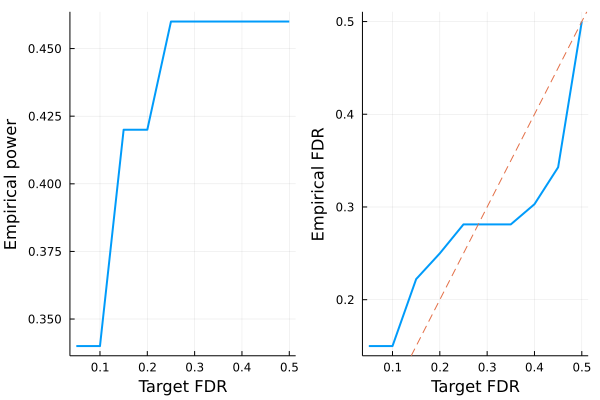

In [28]:
# step 1 (use SDP knockoffs)
Xfull, original, knockoff = merge_knockoffs_with_original(X, Xko_sdp.X̃ )
knockoff_cv = glmnetcv(Xfull, y)
λbest = knockoff_cv.lambda[argmin(knockoff_cv.meanloss)]
βestim = glmnet(Xfull, y, lambda=[λbest]).betas[:, 1]

# target FDR is 0.05, 0.1, ..., 0.5
FDR = collect(0.05:0.05:0.5)
empirical_power = Float64[]
empirical_fdr = Float64[]
for fdr in FDR
    βknockoff = extract_beta(βestim, fdr, original, knockoff) # steps 2-3 happen here

    # compute power and false discovery proportion
    power = length(findall(!iszero, βknockoff) ∩ correct_position) / k
    fdp = length(setdiff(findall(!iszero, βknockoff), correct_position)) / max(count(!iszero, βknockoff), 1)
    push!(empirical_power, power)
    push!(empirical_fdr, fdp)
end

# visualize FDR and power
power_plot = plot(FDR, empirical_power, xlabel="Target FDR", ylabel="Empirical power", legend=false, w=2)
fdr_plot = plot(FDR, empirical_fdr, xlabel="Target FDR", ylabel="Empirical FDR", legend=false, w=2)
Plots.abline!(fdr_plot, 1, 0, line=:dash)
plot(power_plot, fdr_plot)

**Conclusion:** Compared to LASSO, knockoff's empirical FDR is controlled below the target FDR (dashed line). Controlled FDR is compensated by a small price in power. If this experiment is repeated multiple times, we expected the empirical FDR to hug the target (dashed) line more closely. 